# Load module

In [1]:
import sys
sys.path.append('../')

from data import datasets
from data import transforms, target_transforms, augmentations, utils

from ssd.models.ssd300 import SSD300
from ssd.train import *

#from torchvision import transforms > not import!!
from torch.utils.data import DataLoader
from torch.optim.sgd import SGD
from torch.optim.adam import Adam

# Load Dataset

In [2]:
augmentation = augmentations.AugmentationOriginal()

transform = transforms.Compose(
        [transforms.Resize((300, 300)),
         transforms.ToTensor(),
         transforms.Normalize(rgb_means=(0.485, 0.456, 0.406), rgb_stds=(0.229, 0.224, 0.225))]
)
target_transform = target_transforms.Compose(
    [target_transforms.ToCentroids(),
     target_transforms.OneHot(class_nums=datasets.VOC_class_nums),
     target_transforms.ToTensor()]
)
train_dataset = datasets.VOC2007Dataset(ignore=target_transforms.Ignore(difficult=True), transform=transform, target_transform=target_transform, augmentation=augmentation)

train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True,
                          collate_fn=utils.batch_ind_fn,
                         pin_memory=True)
print('{} training images'.format(len(train_dataset)))

9963 training images


# Define model

In [3]:
model = SSD300(class_nums=train_dataset.class_nums, batch_norm=False)
model.load_vgg_weights()
print(model)

SSD300(
  (codec): Codec(
    (encoder): Encoder()
    (decoder): Decoder()
  )
  (defaultBox): DBoxSSD300Original()
  (predictor): Predictor()
  (feature_layers): ModuleDict(
    (convRL1_1): ConvRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (convRL1_2): ConvRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (convRL2_1): ConvRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (convRL2_2): ConvRelu(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (convRL3_1): ConvRelu(
      (conv): C

# Set matplotlib for Jupyter notebook

In [4]:
%matplotlib notebook

# Run training

<IPython.core.display.Javascript object>


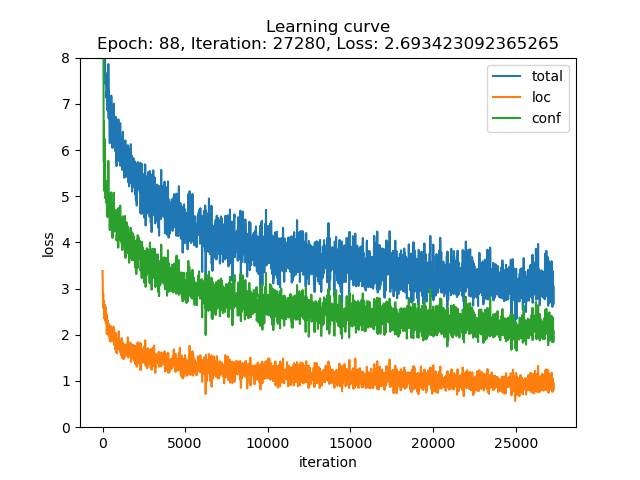

Training... Epoch: 17, Iter: 5000,	 [256/9963	 (3%)]	Loss: 4.574810, Loc Loss: 1.531625, Conf Loss: 3.043184947
Saved model to /home/kado/Desktop/program/machile-learning/pytorch_SSD/weights/checkpoints/ssd300-voc2007_i-0005000_checkpoints20200603.pth

Training... Epoch: 33, Iter: 10000,	 [512/9963	 (5%)]	Loss: 3.732042, Loc Loss: 1.231556, Conf Loss: 2.50048606
Saved model to /home/kado/Desktop/program/machile-learning/pytorch_SSD/weights/checkpoints/ssd300-voc2007_i-0010000_checkpoints20200603.pth

Training... Epoch: 49, Iter: 15000,	 [768/9963	 (8%)]	Loss: 3.199530, Loc Loss: 0.994566, Conf Loss: 2.204964475
Saved model to /home/kado/Desktop/program/machile-learning/pytorch_SSD/weights/checkpoints/ssd300-voc2007_i-0015000_checkpoints20200603.pth

Training... Epoch: 65, Iter: 20000,	 [1024/9963	 (10%)]	Loss: 3.088923, Loc Loss: 0.942720, Conf Loss: 2.1462031
Saved model to /home/kado/Desktop/program/machile-learning/pytorch_SSD/weights/checkpoints/ssd300-voc2007_i-0020000_checkpoints

In [ ]:
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4) # slower
#optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=5e-4) # faster
iter_sheduler = SSDIterMultiStepLR(optimizer, milestones=(40000, 50000), gamma=0.1, verbose=True)

#save_manager = SaveManager(modelname='ssd300-voc2007', interval=10, max_checkpoints=15, plot_yrange=(0, 8))#5000
save_manager = SaveManager(modelname='ssd300-voc2007', interval=5000, max_checkpoints=15, plot_yrange=(0, 8))
log_manager = LogManager(interval=10, save_manager=save_manager, loss_interval=10, live_graph=LiveGraph((0, 8)))
trainer = TrainLogger(model, loss_func=SSDLoss(), optimizer=optimizer, scheduler=iter_sheduler, log_manager=log_manager, gpu=True)

#trainer.train(70, train_loader)
trainer.train(60000, train_loader)